In [7]:
%pip install mediapipe
%pip install opencv-python
%pip install opencv-contrib-python
%pip install Pillow 
%pip install numpy
%pip install pandas
%pip install scikit-learn


  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
   ---------------------------------------- 0.0/10.4 MB ? eta -:--:--
   --- ------------------------------------ 0.8/10.4 MB 6.7 MB/s eta 0:00:02
   ------- -------------------------------- 1.8/10.4 MB 5.6 MB/s eta 0:00:02
   --------- ------------------------------ 2.4/10.4 MB 4.5 MB/s eta 0:00:02
   ------------- -------------------------- 3.4/10.4 MB 4.6 MB/s eta 0:00:02
   ----------------- ---------------------- 4.5/10.4 MB 4.5 MB/s eta 0:00:02
   --------------------- ------------------ 5.5/10.4 MB 4.6 MB/s eta 0:00:02
   --------------------------- ------------ 7.1/10.4 MB 4.8 MB/s eta 0:00:01
   --------------------------------- ------ 8.7/10.4 MB 5.2 MB/s eta 0:00:01
   ------------------------------------- -- 9.7/10.4 MB 5.1 MB/s eta 0:00:01
   ---------------------------------------  10.2/10.4 MB 5.1 MB/s eta 0:00:01
   ---------------------------------------- 10.4/10.4 MB 4.7 MB/s  0:00:02
Using cached absl_py

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\shree\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\cv2\\cv2.pyd'
Consider using the `--user` option or check the permissions.



Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [10]:
%pip install mediapipe




  Using cached mediapipe-0.10.31-py3-none-win_amd64.whl.metadata (9.7 kB)
Using cached mediapipe-0.10.31-py3-none-win_amd64.whl (10.4 MB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
#vision
import cv2
import mediapipe as mp
import numpy as np
#math and time stuff for detection
import math
from time import time as now
import time as time_module
from collections import deque
# visualization
from PIL import Image
from IPython.display import display, clear_output
from mediapipe.tasks import python
from mediapipe.tasks.python import vision


In [2]:
# So I need a function to estimate distance from one point to another, i.e., for face estimation
def euclid(p1,p2):
    return math.sqrt((p1.x-p2.x)**2+(p1.y-p2.y)**2)

In [3]:
class engine:
    def __init__(self):
        base_options = python.BaseOptions(
            model_asset_path="face_landmarker.task"   # so had change this media pipe cause was not compatible with my python 3.10 version
        )
        options = vision.FaceLandmarkerOptions(
            base_options=base_options,
            output_face_blendshapes=False,
            output_facial_transformation_matrixes=False,
            num_faces=2
        )
        self.detector = vision.FaceLandmarker.create_from_options(options)
        # flag for detection of looking away
        self.look_away_st = None
        # to tune
        self.gaze_limit = 4.0
        self.Brow_confusion = 0.28

    def get_gaze(self, landmarks):  # based on eye movement
        iris=landmarks[474]
        inner=landmarks[263]
        outer=landmarks[362]
        eyewidth = euclid(inner, outer)
        if eyewidth == 0:
            return "Center"
        ratio = euclid(iris, inner) / eyewidth
        if ratio < 0.2:
            return "Right"
        elif ratio > 0.8:
            return "Left"
        return "Center"

    def is_confused(self, landmarks):  # confusion logic
        brow_l=landmarks[107]
        brow_r=landmarks[336]
        face_l=landmarks[234]
        face_r=landmarks[454]
        facewidth=euclid(face_l, face_r)
        if facewidth == 0:
            return False, 0.0
        brow_dist=euclid(brow_l, brow_r)
        ratio=brow_dist / facewidth
        return ratio < self.Brow_confusion, ratio

    def process(self, frame):  # processing the image
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        mp_image = mp.Image(
            image_format=mp.ImageFormat.SRGB,
            data=rgb
        )
        result = self.detector.detect(mp_image)
        status = "No Face"
        state = "Neutral"
        gaze = "Center"
        if not result.face_landmarks:
            return status, state, gaze
        if len(result.face_landmarks) > 1:
            return "Multiple Faces", "Alert", gaze
        landmarks = result.face_landmarks[0]
        # studying the gaze
        gaze = self.get_gaze(landmarks)

        if gaze != "Center":
            if self.look_away_st is None:
                self.look_away_st = now()
            elif now() - self.look_away_st > self.gaze_limit:
                return "Looking away", "Alert", gaze
        else:
            self.look_away_st = None

        confused, ratio = self.is_confused(landmarks)
        if confused:
            return "Confused", "Confused", gaze

        return "Focused", "Focused", gaze


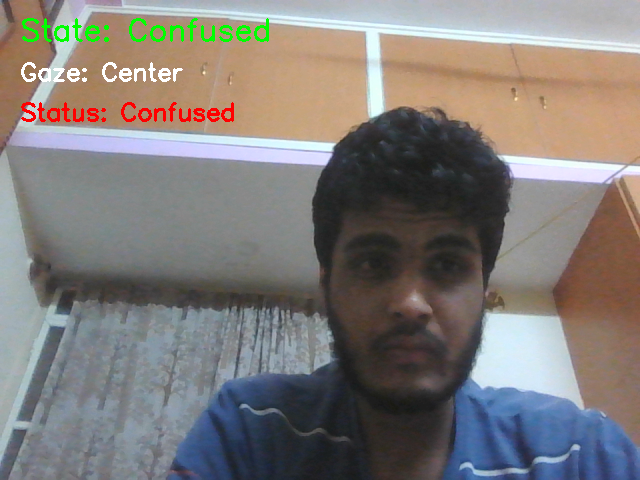

In [ ]:

engine1=engine()
cap=cv2.VideoCapture(0)#camera
cap.set(cv2.CAP_PROP_BUFFERSIZE, 1)
while cap.isOpened():
    ret,frame=cap.read()
    if not ret:
        break

    status, state, gaze = engine1.process(frame)
    # displaying text on the camera with our logic
    cv2.putText(frame, f"State: {state}", (20, 40),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
    cv2.putText(frame, f"Gaze: {gaze}", (20, 80),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,255), 2)
    cv2.putText(frame, f"Status: {status}", (20, 120),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,0,255), 2)
    # displaying it on jupyter
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    display(Image.fromarray(frame_rgb))
    clear_output(wait=True)
    time_module.sleep(0.06)
cap.release()




In [ ]:
#so what was happening was the eyebrow motion are extremely sensitive so it was just returning confused all the time 
#and would vary a lot so i had two options manually train and figure out the eye brow optimal or just train it with data set for optimal way
#so i opted for the latter  and the gaze is working pretty fine just need to add up and down head tilt logic
# this will be available in mediapipe_test2 notebook
